# Battery Electric Vehicle Charging

In this example a battery electric vehicle (BEV) is driven 100 km in the morning and 100 km in the evening, to simulate commuting, and charged during the day by a solar panel at the driver's place of work. The size of the panel is computed by the optimisation.

The BEV has a battery of size 100 kWh and an electricity consumption of 0.18 kWh/km.

In [10]:
import pypsa

import pandas as pd

%matplotlib inline

In [11]:
# NB: this example will use units of kW and kWh, unlike the PyPSA defaults

# use 24 hour period for consideration
index = pd.date_range("2016-01-01 00:00","2016-01-01 23:00",freq="H")

# consumption pattern of BEV
bev_usage = pd.Series([0.]*7 + [9.]*2 + [0.]*8 + [9.]*2 + [0.]*5,index)

# solar PV panel generation per unit of capacity
pv_pu = pd.Series([0.]*7 + [0.2,0.4,0.6,0.75,0.85,0.9,0.85,0.75,0.6,0.4,0.2,0.1] + [0.]*5,index)

# availability of charging - i.e. only when parked at office
charger_p_max_pu = pd.Series(0.,index=index)
charger_p_max_pu["2016-01-01 09:00":"2016-01-01 16:00"] = 1.

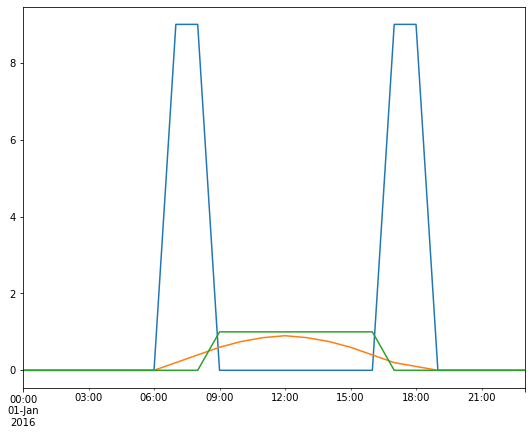

In [13]:
bev_usage.plot()
pv_pu.plot()
charger_p_max_pu.plot(figsize = (9,7))

In [14]:

network = pypsa.Network()

network.set_snapshots(index)

network.add("Bus",
            "place of work",
            carrier="AC")

network.add("Bus",
            "battery",
            carrier="Li-ion")

network.add("Generator",
            "PV panel",
            bus="place of work",
            p_nom_extendable=True,
            p_max_pu=pv_pu,
            capital_cost=1000.)

network.add("Load",
            "driving",
            bus="battery",
            p_set=bev_usage)

network.add("Link",
            "charger",
            bus0="place of work",
            bus1="battery",
            p_nom=120,  #super-charger with 120 kW
            p_max_pu=charger_p_max_pu,
            efficiency=0.9)    


network.add("Store",
            "battery storage",
            bus="battery",
            e_cyclic=True,
            e_nom=100.)

In [15]:
network.lopf(network.snapshots)
print("Objective:",network.objective)

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 7017.54385964912
  Upper bound: 7017.54385964912
  Number of objectives: 1
  Number of constraints: 169
  Number of variables: 98
  Number of nonzeros: 277
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.05108141899108887
# ----------------------------------------------------------
#   Solution Information
# ----------

In [16]:
print("Pannel size [kW]:",network.generators.p_nom_opt["PV panel"])

Pannel size [kW]: 7.01754385964912


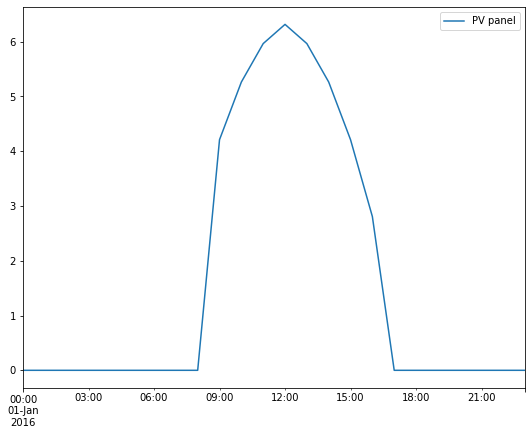

In [17]:
network.generators_t.p.plot(figsize = (9,7))

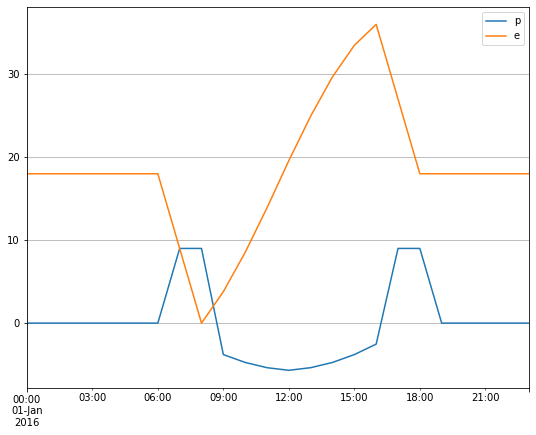

In [18]:
pd.DataFrame({attr: network.stores_t[attr]["battery storage"] for attr in ["p","e"]}).plot(grid=True, figsize = (9,7))

In [19]:
print("Losses [kWh/d]:",network.generators_t.p.loc[:,"PV panel"].sum() - network.loads_t.p.loc[:,"driving"].sum())

Losses [kWh/d]: 3.9999999999999716


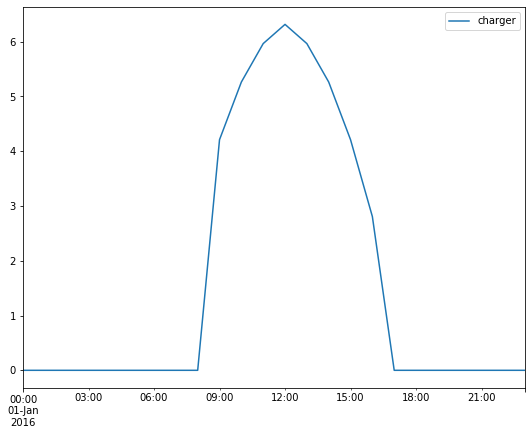

In [20]:
network.links_t.p0.plot(figsize = (9,7))